# Table of contents

* [Import Libraries](#Import-Libraries)
* [Functions](#Functions)
* [First Question](#First-Question)
    * [Load in information needed](#Load-in-information-needed)
    * [Checkout the information](#Checkout-the-information)
    * [Answering the Hypothosis](#Answering-the-Hypothosis)
    * [Effect size of discount](#Effect-size-of-discount)
    * [What amount of discount makes the most difference with regards to quantity ordered?](#What-amount-of-discount-makes-the-most-difference-with-regards-to-quantity-ordered?)
    * [Effect sizes of each Discount amount](#Effect-sizes-of-each-Discount-amount)
    * [Conclusion](#Conclusion)
* [Second Question](#Second-Question)
    * [Load in information needed for 2nd question](#Load-in-information-needed-for-2nd-question)
    * [Checkout the information for the 2nd question](#Checkout-the-information-for-the-2nd-question)
    * [Answering the 2nd question](#Answering-the-2nd-question)
    * [Conclusion for 2nd question](#Conclusion-for-2nd-question)
* [Third Question](#Third-Question)

## Import Libraries 

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower

In [97]:
power_analysis = TTestIndPower()

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
c = conn.cursor()

[Return to contents](#Table-of-contents)

## Functions

In [154]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d

In [248]:
def Cohen_d_list(group1, group2):

    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d

In [217]:
def bootstrap(sample, n):
    boots = []
    for i in range(n):
        boot = sample.sample(n=len(sample), replace=True)
        boots.append(boot)
    return boots

## Northwind Database Map

<img src='Northwind_ERD_updated.png'>

# First Question

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?  

Null Hypothosis: Discount does not affect quantity of product ordered  
Alternative Hypthosis: Discount does effect the quantity of product ordered  
Alpha: .05  

[Return to contents](#Table-of-contents)

## Load in information needed

In [211]:
c.execute('''Select * from OrderDetail;''')
discountdf = pd.DataFrame(c.fetchall())
discountdf.columns = [x[0] for x in c.description]
discountdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


[Return to contents](#Table-of-contents)

## Checkout the information

I want to first see how many items have discounts and how the discount is represented, by dollars or percentage

In [40]:
discountdf.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

It seems to be in percentages and we have 838 items that had a discount on them when ordered

In [41]:
discountdf.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Checking for Null values

In [42]:
discountdf.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

No null values

Checking for placeholder values

In [43]:
discountdf.Quantity.unique()

array([ 12,  10,   5,   9,  40,  35,  15,   6,  20,  25,  42,  21,  30,
        50,  65,   1,  16,   2,  60,  28,  36,  70,   4,  24,  33,   7,
         8,  18,   3,  45, 100,  14,  80,  48,  56,  13,  77,  54,  55,
        32, 120,  49,  90,  39,  84,  11, 110,  27,  44, 130,  52,  91,
        66,  63,  22], dtype=int64)

In [44]:
discountdf.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

[Return to contents](#Table-of-contents)

## Answering the Hypothosis

Make a column that has a 1 if there is a discount and a 0 if there is not a discount

In [212]:
discountdf['is_discount'] = 1
discountdf.loc[discountdf.Discount == 0, 'is_discount'] = 0

In [213]:
discountdf.tail()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
2150,11077/64,11077,64,33.25,2,0.03,1
2151,11077/66,11077,66,17.00,1,0.00,0
2152,11077/73,11077,73,15.00,2,0.01,1
2153,11077/75,11077,75,7.75,4,0.00,0
2154,11077/77,11077,77,13.00,2,0.00,0


Test Hypothosis One with an Anova table as I am dealing with categorical data

In [47]:
formula1 = 'Quantity ~ C(is_discount)'
lm = ols(formula1, discountdf).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df          F        PR(>F)
C(is_discount)   14903.513199     1.0  41.971781  1.144092e-10
Residual        764496.122996  2153.0        NaN           NaN


Very low P-Value so I can reject the Null Hypothosis that discount does not have an affect on quantity ordered

[Return to contents](#Table-of-contents)

## Effect size of discount

To figure out how much of an effect a discount has on the quantity ordered, I will split the information into 2 dataframes, one for discounts and one for no discount

In [53]:
discountdf_discount = discountdf.loc[discountdf.is_discount == 1]
discountdf_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
6,10250/51,10250,51,42.4,35,0.15,1
7,10250/65,10250,65,16.8,15,0.15,1
8,10251/22,10251,22,16.8,6,0.05,1
9,10251/57,10251,57,15.6,15,0.05,1
11,10252/20,10252,20,64.8,40,0.05,1


In [54]:
discountdf_no_discount = discountdf.loc[discountdf.is_discount == 0]
discountdf_no_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


Let's see what the average quantity ordered is for discount and no discount

In [57]:
discountdf_discount.Quantity.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [58]:
discountdf_no_discount.Quantity.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

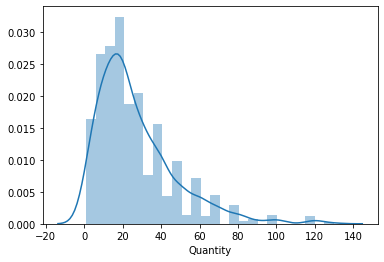

In [64]:
sns.distplot(discountdf_discount.Quantity);

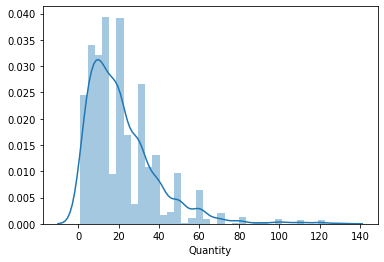

In [65]:
sns.distplot(discountdf_no_discount.Quantity);

It seems we need to cut down on outliers so I will do that now.  
First to see where I should cut them.  
My guess is around 70 for the discount one and probably around the same for no discount

In [81]:
discountdf_discount.Quantity.quantile(.95)

70.0

In [84]:
discountdf_no_discount.Quantity.quantile(.95)

55.0

In [106]:
discountdf_discount = discountdf.loc[(discountdf.is_discount == 1) & (discountdf.Quantity <= 70)]
discountdf_no_discount = discountdf.loc[(discountdf.is_discount == 0) & (discountdf.Quantity <= 55)]

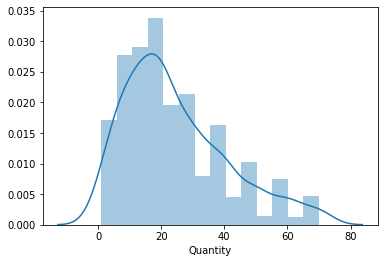

In [86]:
sns.distplot(discountdf_discount.Quantity);

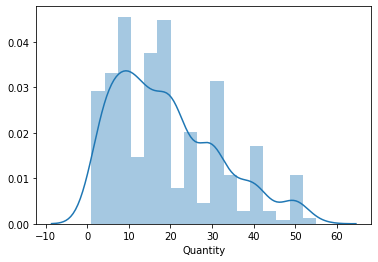

In [87]:
sns.distplot(discountdf_no_discount.Quantity);

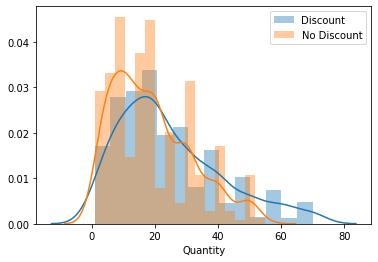

In [142]:
sns.distplot(discountdf_discount.Quantity, label='Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

In [90]:
discountdf_discount.Quantity.describe()

count    809.000000
mean      24.716934
std       16.485674
min        1.000000
25%       12.000000
50%       20.000000
75%       35.000000
max       70.000000
Name: Quantity, dtype: float64

In [94]:
discountdf_no_discount.Quantity.describe()

count    1252.000000
mean       19.031150
std        12.550769
min         1.000000
25%        10.000000
50%        16.000000
75%        28.000000
max        55.000000
Name: Quantity, dtype: float64

In [177]:
discountdf_discount.Quantity.mean() - discountdf_no_discount.Quantity.mean()

5.685784327276604

In [178]:
effect_size = Cohen_d(discountdf_discount.Quantity, discountdf_no_discount.Quantity)
effect_size

0.39968417727067845

In [181]:
power_analysis.solve_power(effect_size=effect_size, alpha=.05, nobs1=len(discountdf_discount))

1.0

Our effect size is 5.68 items and Cohen's D tells us that this effect is close to medium range.  
The power tells us that our chances of type 2 errors is extremely low.

[Return to contents](#Table-of-contents)

### What amount of discount makes the most difference with regards to quantity ordered?

In [113]:
discount_dummies = pd.get_dummies(discountdf_discount.Discount, prefix='Dis')

In [116]:
discountdf_discount = pd.concat([discountdf_discount, discount_dummies], axis=1)
discountdf_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount,Dis_0.01,Dis_0.02,Dis_0.03,Dis_0.04,Dis_0.05,Dis_0.06,Dis_0.1,Dis_0.15,Dis_0.2,Dis_0.25
6,10250/51,10250,51,42.4,35,0.15,1,0,0,0,0,0,0,0,1,0,0
7,10250/65,10250,65,16.8,15,0.15,1,0,0,0,0,0,0,0,1,0,0
8,10251/22,10251,22,16.8,6,0.05,1,0,0,0,0,1,0,0,0,0,0
9,10251/57,10251,57,15.6,15,0.05,1,0,0,0,0,1,0,0,0,0,0
11,10252/20,10252,20,64.8,40,0.05,1,0,0,0,0,1,0,0,0,0,0


In [130]:
discountdf_discount.rename(columns={'Dis_0.01': 'Dis_01', 'Dis_0.02': 'Dis_02', 'Dis_0.03': 'Dis_03', 'Dis_0.04': 'Dis_04', 'Dis_0.05': 'Dis_05', 'Dis_0.06': 'Dis_06', 'Dis_0.1': 'Dis_1', 'Dis_0.15': 'Dis_15', 'Dis_0.2': 'Dis_2', 'Dis_0.25': 'Dis_25'}, inplace=True)

In [131]:
discountdf_discount.columns

Index(['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount',
       'is_discount', 'Dis_01', 'Dis_02', 'Dis_03', 'Dis_04', 'Dis_05',
       'Dis_06', 'Dis_1', 'Dis_15', 'Dis_2', 'Dis_25'],
      dtype='object')

See how many of each category we have

In [134]:
discountdf_discount.sum()

Id             10250/5110250/6510251/2210251/5710252/2010252/...
OrderId                                                  8618230
ProductId                                                  32066
UnitPrice                                                21389.1
Quantity                                                   19996
Discount                                                  117.19
is_discount                                                  809
Dis_01                                                         1
Dis_02                                                         2
Dis_03                                                         3
Dis_04                                                         1
Dis_05                                                       177
Dis_06                                                         1
Dis_1                                                        167
Dis_15                                                       150
Dis_2                    

In [136]:
discountdf_discount['Dis_1_to_6'] = 0
discountdf_discount.loc[(discountdf_discount.Dis_01 == 1) | (discountdf_discount.Dis_02 == 1) | (discountdf_discount.Dis_03 == 1) | (discountdf_discount.Dis_04 == 1) | (discountdf_discount.Dis_05 == 1) | (discountdf_discount.Dis_06 == 1), 'Dis_1_to_6'] = 1 

In [138]:
discountdf_discount.tail()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount,Dis_01,Dis_02,Dis_03,Dis_04,Dis_05,Dis_06,Dis_1,Dis_15,Dis_2,Dis_25,Dis_1_to_6
2144,11077/39,11077,39,18.00,2,0.05,1,0,0,0,0,1,0,0,0,0,0,1
2146,11077/46,11077,46,12.00,3,0.02,1,0,1,0,0,0,0,0,0,0,0,1
2149,11077/60,11077,60,34.00,2,0.06,1,0,0,0,0,0,1,0,0,0,0,1
2150,11077/64,11077,64,33.25,2,0.03,1,0,0,1,0,0,0,0,0,0,0,1
2152,11077/73,11077,73,15.00,2,0.01,1,1,0,0,0,0,0,0,0,0,0,1


As all the lower discounts only have 1-3 of each I grouped them into one category

In [139]:
formula1a = 'Quantity ~ C(Dis_1_to_6) + C(Dis_1) + C(Dis_15) + C(Dis_2) + C(Dis_25)'
lm = ols(formula1a, discountdf_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df          F    PR(>F)
C(Dis_1_to_6)    2571.647211    1.0   9.479863  0.002148
C(Dis_1)          704.681547    1.0   2.597668  0.107414
C(Dis_15)        4574.067310    1.0  16.861384  0.000044
C(Dis_2)         4555.651958    1.0  16.793500  0.000046
C(Dis_25)        6051.074474    1.0  22.306076  0.000003
Residual       218104.875547  804.0        NaN       NaN


We can reject the null hypothosis only with discounts of .05, .15, .2 and .25 while with a 10% discount we can not reject the null hypothosis that it is not better then not having a discount

[Return to contents](#Table-of-contents)

## Effect sizes of each Discount amount

In [163]:
Dis_1_to_6df = discountdf_discount.loc[discountdf_discount.Dis_1_to_6 == 1]

In [160]:
Dis_1_to_6df.Quantity.mean() - discountdf_no_discount.Quantity.mean()

5.017498488904238

In [182]:
Dis_1_to_6_effect = Cohen_d(Dis_1_to_6df.Quantity, discountdf_no_discount.Quantity)
Dis_1_to_6_effect

0.37719965122765065

In [184]:
power_analysis.solve_power(effect_size=Dis_1_to_6_effect, alpha=.05, nobs1=len(Dis_1_to_6df))

0.9513758248551824

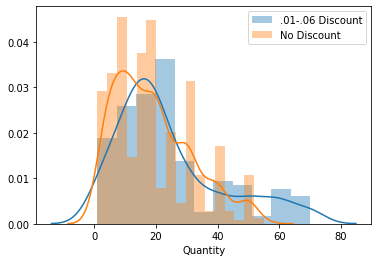

In [193]:
sns.distplot(Dis_1_to_6df.Quantity, label='.01-.06 Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

In [164]:
Dis_1df = discountdf_discount.loc[discountdf_discount.Dis_1 == 1]

In [165]:
Dis_1df.Quantity.mean() - discountdf_no_discount.Quantity.mean()

3.4778318761837355

In [185]:
Dis_1_effect = Cohen_d(Dis_1df.Quantity, discountdf_no_discount.Quantity)
Dis_1_effect

0.26979236928886313

In [186]:
power_analysis.solve_power(effect_size=Dis_1_effect, alpha=.05, nobs1=len(Dis_1df))

0.6908394252830017

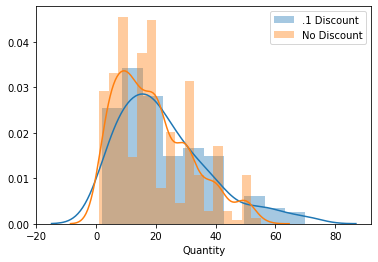

In [194]:
sns.distplot(Dis_1df.Quantity, label='.1 Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

In [318]:
boot_10discount = []
for i in range(30):
    a = np.mean(bootstrap(Dis_1df.Quantity, 1))
    boot_10discount.append(a)
np.mean(boot_10discount)

22.342714570858284

In [319]:
Dis_10_effect2 = Cohen_d_list(boot_10discount, boot_no_discount)
Dis_10_effect2

2.9065716818909357

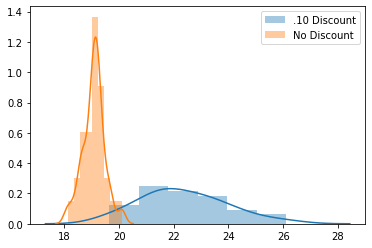

In [322]:
sns.distplot(boot_10discount, label='.10 Discount')
sns.distplot(boot_no_discount, label='No Discount')
plt.legend()

In [323]:
power_analysis.solve_power(effect_size=Dis_10_effect2, alpha=.05, nobs1=len(Dis_1df))

1.0

As we see from the effect size and Cohen's D, the effect of a %10 discount is low, so this confirms our P-value above that told us the same thing.  
We also have a power under .8 so our type 2 errors would be higher as well

In [171]:
Dis_15df = discountdf_discount.loc[discountdf_discount.Dis_15 == 1]

In [172]:
Dis_15df.Quantity.mean() - discountdf_no_discount.Quantity.mean()

6.555516506922256

In [312]:
boot_15discount = []
for i in range(30):
    a = np.mean(bootstrap(Dis_15df.Quantity, 1))
    boot_15discount.append(a)
np.mean(boot_15discount)

25.68911111111111

In [315]:
Dis_15_effect = Cohen_d_list(Dis_15df.Quantity, discountdf_no_discount.Quantity)
Dis_15_effect

0.5025004528958542

In [314]:
Dis_15_effect = Cohen_d_list(boot_15discount, boot_no_discount)
Dis_15_effect

5.70453172732082

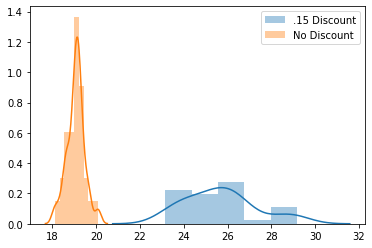

In [316]:
sns.distplot(boot_15discount, label='.15 Discount')
sns.distplot(boot_no_discount, label='No Discount')
plt.legend()

In [188]:
power_analysis.solve_power(effect_size=Dis_15_effect, alpha=.05, nobs1=len(Dis_15df))

0.9911967332800209

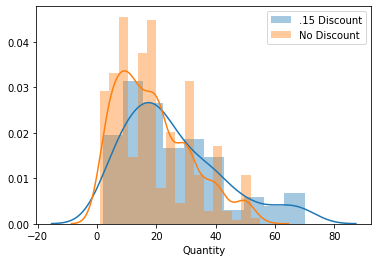

In [195]:
sns.distplot(Dis_15df.Quantity, label='.15 Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

In [168]:
Dis_2df = discountdf_discount.loc[discountdf_discount.Dis_2 == 1]

In [169]:
Dis_2df.Quantity.mean() - discountdf_no_discount.Quantity.mean()

6.452926273376608

In [189]:
Dis_2_effect = Cohen_d(Dis_2df.Quantity, discountdf_no_discount.Quantity)
Dis_2_effect

0.49551262223158243

In [190]:
power_analysis.solve_power(effect_size=Dis_2_effect, alpha=.05, nobs1=len(Dis_2df))

0.9921698362954489

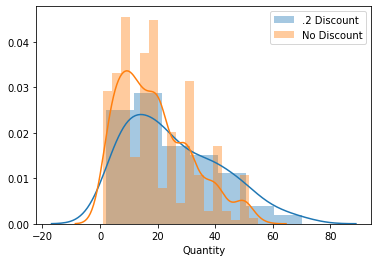

In [196]:
sns.distplot(Dis_2df.Quantity, label='.2 Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

In [174]:
Dis_25df = discountdf_discount.loc[discountdf_discount.Dis_25 == 1]

In [175]:
Dis_25df.Quantity.mean() - discountdf_no_discount.Quantity.mean()

7.295516506922258

In [191]:
Dis_25_effect = Cohen_d(Dis_25df.Quantity, discountdf_no_discount.Quantity)
Dis_25_effect

0.5605543292057493

In [192]:
power_analysis.solve_power(effect_size=Dis_25_effect, alpha=.05, nobs1=len(Dis_25df))

0.9980045233287141

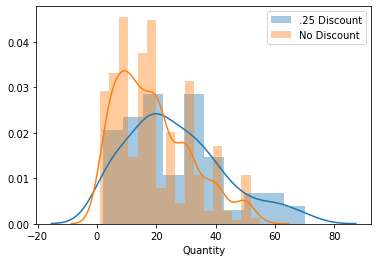

In [197]:
sns.distplot(Dis_25df.Quantity, label='.25 Discount')
sns.distplot(discountdf_no_discount.Quantity, label='No Discount')
plt.legend()

The discounts from 15-25% drive much more quantity of sales as seen from the effect sizes and Cohen's D of each one.  
We also have very high power for .05, .15, .2 and .25 so our type 2 errors should be very low for them as well.

[Return to contents](#Table-of-contents)

## Average profit from each discount level

In [209]:
c.execute('''Select p.Id as ProductTableId, p.UnitPrice as ProductUnitPrice 
            from OrderDetail o
            join Product p
            on o.ProductId = p.Id;''')
product_pricedf = pd.DataFrame(c.fetchall())
product_pricedf.columns = [x[0] for x in c.description]
product_pricedf.head()

,ProductTableId,ProductUnitPrice
0,11,21.00
1,42,14.00
2,72,34.80
3,14,23.25
4,51,53.00


In [205]:
len(product_pricedf)

2155

In [206]:
len(discountdf)

2155

In [214]:
discountdf = pd.concat([discountdf, product_pricedf], axis=1)
discountdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount,ProductTableId,ProductUnitPrice
0,10248/11,10248,11,14.0,12,0.0,0,11,21.00
1,10248/42,10248,42,9.8,10,0.0,0,42,14.00
2,10248/72,10248,72,34.8,5,0.0,0,72,34.80
3,10249/14,10249,14,18.6,9,0.0,0,14,23.25
4,10249/51,10249,51,42.4,40,0.0,0,51,53.00


There is an issue here as the product unit price is somtimes higher than the sale price.  
This could be my misinterpretation of what the column means or this could be an error or have to do with how I made the query, not sure and will need to check further into it

[Return to contents](#Table-of-contents)

## Conclusion

We can recommend using .05%, .15%, .2% and .25% as discount amounts to try and drive sales.  
.05% discounts have a smaller but still statistically significant effect, while .15-.25% discounts have a bigger effect

[Return to contents](#Table-of-contents)

## Answering above with bootstrapping to see if there is a difference

In [299]:
boot_discount = []
for i in range(30):
    a = np.mean(bootstrap(discountdf_discount.Quantity, 1))
    boot_discount.append(a)
np.mean(boot_discount)

24.64808405438814

In [289]:
np.mean(discountdf_discount.Quantity)

24.716934487021014

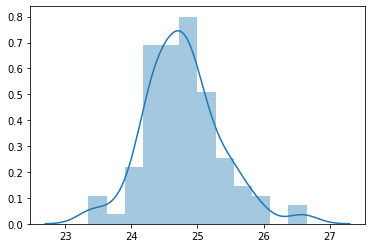

In [290]:
sns.distplot(boot_discount)

In [298]:
boot_no_discount = []
for i in range(30):
    a = np.mean(bootstrap(discountdf_no_discount.Quantity, 1))
    boot_no_discount.append(a)
np.mean(boot_no_discount)

19.071645367412142

In [292]:
np.std(boot_no_discount)

0.36225753849496284

In [293]:
np.mean(discountdf_no_discount.Quantity)

19.03115015974441

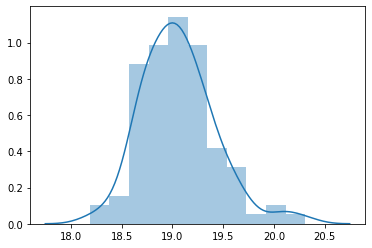

In [294]:
sns.distplot(boot_no_discount)

In [301]:
np.mean(boot_discount) - np.mean(boot_no_discount)

5.576438686975997

In [302]:
np.std(boot_no_discount)

0.3977226857741069

In [300]:
Cohen_d_list(boot_discount, boot_no_discount)

10.407938484607476

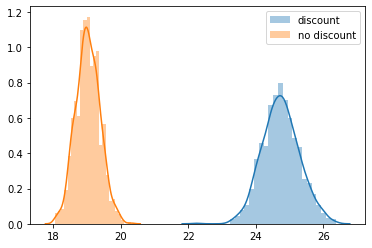

In [277]:
sns.distplot(boot_discount, label='discount')
sns.distplot(boot_no_discount, label='no discount')
plt.legend()
plt.show()

In [279]:
stats.shapiro(boot_discount)

(0.9971635341644287, 0.07488884776830673)

In [280]:
stats.shapiro(boot_no_discount)

(0.9981669187545776, 0.3597007095813751)

In [308]:
stats.levene(boot_discount, boot_no_discount)

LeveneResult(statistic=4.24036045408109, pvalue=0.043972986585232)

In [311]:
stats.ttest_ind(boot_discount, boot_no_discount, equal_var=False)

Ttest_indResult(statistic=39.63224899927978, pvalue=1.7563001654257458e-38)

# Second Question

Which product sells the best per order? Also which are the top 5 products sold per order?  
  
H0 = all quantity of each product sold per order, means are equal  
Ha = all quantity of each product sold per order, means are not equal  
alpha = .05

[Return to contents](#Table-of-contents)

## Load in information needed for 2nd question

In [329]:
c.execute('''Select * from OrderDetail order by ProductId;''')
ordersdf = pd.DataFrame(c.fetchall())
ordersdf.columns = [x[0] for x in c.description]
ordersdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10285/1,10285,1,14.4,45,0.20
1,10294/1,10294,1,14.4,18,0.00
2,10317/1,10317,1,14.4,20,0.00
3,10348/1,10348,1,14.4,15,0.15
4,10354/1,10354,1,14.4,12,0.00


[Return to contents](#Table-of-contents)

## Checkout the information for the 2nd question

Put all the product numbers in a list and them make a dict of dataframes for each one

In [338]:
product_numbers = list(ordersdf.ProductId.unique())
print(product_numbers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


In [339]:
product_dict = {}
for product in product_numbers:
    product_dict[product] = ordersdf.loc[ordersdf.ProductId == product]

In [342]:
product_dict[1].Quantity.mean()

21.789473684210527

Make a dict of the mean ordered per order for each product

In [349]:
product_means_dict = {}
for product in product_numbers:
    product_means_dict[product] = product_dict[product].Quantity.mean()

In [350]:
product_means_dict[1]

21.789473684210527

Make a dict of the amount of orders for each product so we can better asses which products are the best ones on a more regular basis and not due to a few big sales

In [351]:
orders_amount_dict = {}
for product in product_numbers:
    orders_amount_dict[product] = len(product_dict[product].OrderId.unique())    

In [353]:
orders_amount_dict[1]

38

I would also like to see total ordered just to have it as a reference

In [432]:
Total_ordered_per_product = {}
for product in product_numbers:
    Total_ordered_per_product[product] = sum(product_dict[product].Quantity)

Combine those dicts into a dataframe

In [358]:
productsdf = pd.DataFrame()

In [433]:
productsdf['ProductId'] = product_means_dict.keys()
productsdf['Mean_ordered_per_order'] = product_means_dict.values()
productsdf['Number_of_orders'] = orders_amount_dict.values()
productsdf['Total_ordered'] = Total_ordered_per_product.values()

In [434]:
productsdf.head(15)

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
0,1,21.789474,38,828
1,2,24.022727,44,1057
2,3,27.333333,12,328
3,4,22.650000,20,453
4,5,29.800000,10,298
5,6,25.083333,12,301
6,7,26.310345,29,763
7,8,28.615385,13,372
8,9,19.000000,5,95
9,10,22.484848,33,742


Check distributions of number of orders and mean ordered

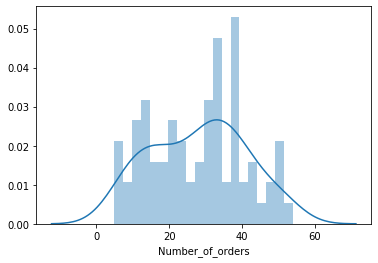

In [372]:
sns.distplot(productsdf.Number_of_orders, bins=20)

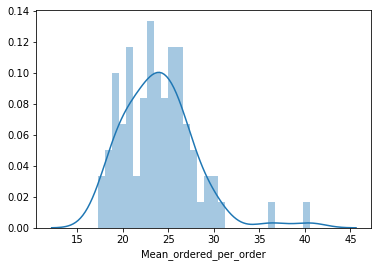

In [381]:
sns.distplot(productsdf.Mean_ordered_per_order, bins=30)

Making a box plot to spot outliers that have few big orders

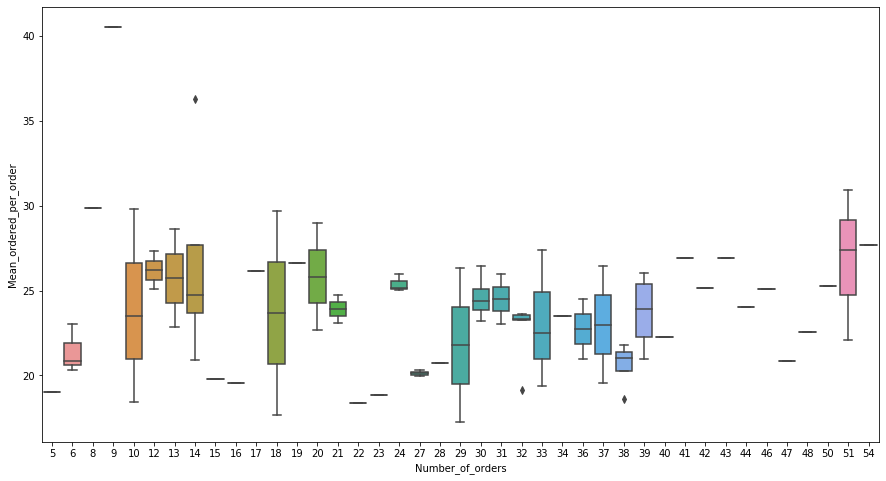

In [426]:
plt.figure(figsize=(15,8))
sns.boxplot(productsdf.Number_of_orders, productsdf.Mean_ordered_per_order)

To find the outliers, I will sort by mean ordered

In [435]:
productsdf.sort_values(by=['Mean_ordered_per_order'], ascending=False).head(10)

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
26,27,40.555556,9,365
44,45,36.285714,14,508
59,60,30.921569,51,1577
65,66,29.875000,8,239
4,5,29.800000,10,298
57,58,29.666667,18,534
22,23,29.000000,20,580
7,8,28.615385,13,372
58,59,27.703704,54,1496
30,31,27.392157,51,1397


As can be seen product 27, 45 are major outliers while there are also more that are at about 20 orders or below with higher order amounts.  
You can also see from the total ordered column a good metric for telling if there are a lot of products being sold or it is just a few big sales. For example compare product number 60 on line 3 above and product number 27 on line 1 above.       
To narrow down the best selling on a more regular basis, I will sort by number of orders

In [436]:
productsdf.sort_values(by=['Number_of_orders'], ascending=False).head(10)

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
58,59,27.703704,54,1496
59,60,30.921569,51,1577
30,31,27.392157,51,1397
23,24,22.058824,51,1125
55,56,25.260000,50,1263
61,62,22.562500,48,1083
40,41,20.872340,47,981
74,75,25.108696,46,1155
1,2,24.022727,44,1057
15,16,26.930233,43,1158


I want to find the best ones, so I will check the mean and quantiles of the df

In [437]:
productsdf.describe()

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
count,77.000000,77.000000,77.000000,77.000000
mean,39.000000,23.917082,27.987013,666.454545
std,22.371857,3.995918,12.944714,329.244492
min,1.000000,17.241379,5.000000,95.000000
25%,20.000000,20.928571,17.000000,404.000000
50%,39.000000,23.500000,30.000000,697.000000
75%,58.000000,26.051282,38.000000,828.000000
max,77.000000,40.555556,54.000000,1577.000000


I will slice the df on the 75th percentile of the means and number of orders as these would seem to be the best performing based on both mean ordered and number of orders

In [477]:
best_mean_and_orders = productsdf.loc[(productsdf.Mean_ordered_per_order >= 26) & (productsdf.Number_of_orders >= 38)]
best_mean_and_orders

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
15,16,26.930233,43,1158
20,21,26.051282,39,1016
30,31,27.392157,51,1397
39,40,26.902439,41,1103
58,59,27.703704,54,1496
59,60,30.921569,51,1577


We are left with 6 products that I would say are the best ones for selling a lot of products on a regular schedule.  
This can be confirmed by looking at the total ordered column as well.

I would also suggest looking at anything on this list that sells more then 1016 items overall, even though they are not on the above list, as they would all be good performers as well.  
This would conteract any bais of good performers that do not fit the above criteria.

In [479]:
high_quantity = productsdf.loc[productsdf.Total_ordered >= 1016].sort_values(by=['Total_ordered'], ascending=False).drop(best_mean_and_orders.index, axis=0)
high_quantity

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
55,56,25.260000,50,1263
74,75,25.108696,46,1155
23,24,22.058824,51,1125
61,62,22.562500,48,1083
1,2,24.022727,44,1057
70,71,25.166667,42,1057


[Return to contents](#Table-of-contents)

## Answering the 2nd question

I will do a 1 sample T-test to see if the mean of the products are equal to the mean of quantity per order.  
If all means are equal then the p-value should be low

In [430]:
stats.ttest_1samp(productsdf.Mean_ordered_per_order, ordersdf.Quantity.mean())

Ttest_1sampResult(statistic=0.22857749391703608, pvalue=0.8198112481362494)

As we have a high p-value we reject the null hypthosis that the means are equal

[Return to contents](#Table-of-contents)

## Conclusion for 2nd question

I would suggest the company focus on these items as they seem to be the best preforming based on both volume per sale and volume of sales

In [480]:
best_mean_and_orders

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
15,16,26.930233,43,1158
20,21,26.051282,39,1016
30,31,27.392157,51,1397
39,40,26.902439,41,1103
58,59,27.703704,54,1496
59,60,30.921569,51,1577


I also would suggest focusing on these products that did not make it into that list but are very good sellers based on quantity

In [482]:
high_quantity

,ProductId,Mean_ordered_per_order,Number_of_orders,Total_ordered
55,56,25.260000,50,1263
74,75,25.108696,46,1155
23,24,22.058824,51,1125
61,62,22.562500,48,1083
1,2,24.022727,44,1057
70,71,25.166667,42,1057


Even though I suggested more then 5 products, this seems to give a better picture based on all the factors then just 5

[Return to contents](#Table-of-contents)

## Third Question

[Return to contents](#Table-of-contents)

In [198]:
c.execute('''select name from sqlite_master where type = 'table';''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]